<a href="https://www.kaggle.com/code/himanshunayal/sign-language-model-ensembling?scriptVersionId=96803548" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import math
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical, Sequence
from keras.models import load_model
from sklearn.metrics import accuracy_score

# The main aim of this notebook is to show implementation of model ensembling.

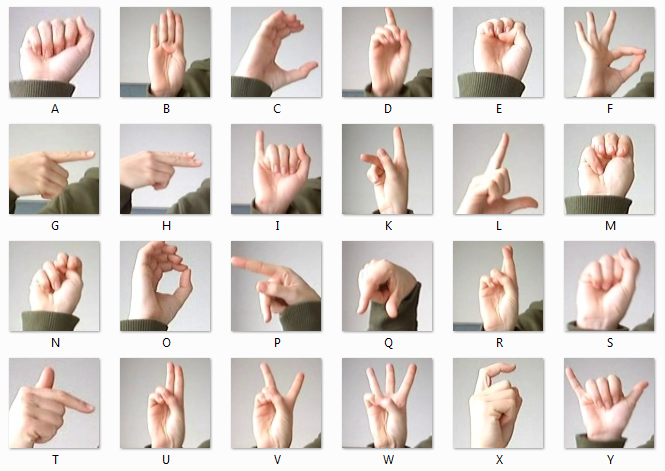

In [2]:
Image.open('../input/sign-language-mnist/amer_sign2.png')

In [3]:
train = pd.read_csv('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [4]:
train.shape, test.shape

((27455, 785), (7172, 785))

In [5]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]

# Class Distribution

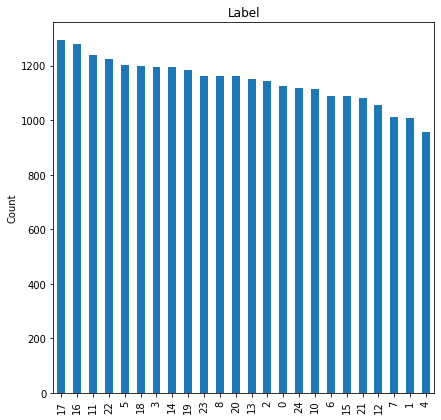

In [6]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
train['label'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Label')
fig.show()

# Normalization

First column is the label column.

In [7]:
train_data = np.array(train, dtype = 'float32')
test_data = np.array(test, dtype='float32')

In [8]:
# Normalization
X_train = train_data[:, 1:] /255.
X_test = test_data[:, 1:] /255.

In [9]:
# one_hot_encoding the labels
y_train = train_data[:, 0]
y_train_cat = to_categorical(y_train, num_classes=25)

y_test = test_data[:,0]
y_test_cat = to_categorical(y_test, num_classes=25)

In [10]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

# Loading Batches(No Need here)

***You don't need batchloader here as model.fit has it's own argument 'batch_size' for batch loading .***

In [11]:
class SignSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size : (idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) *self.batch_size]

        return batch_x, batch_y

In [12]:
train_loader = SignSequence(X_train,y_train_cat,batch_size=128)
test_loader = SignSequence(X_test,y_test_cat,batch_size=128)

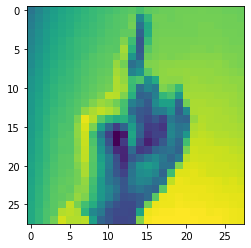

Label: D


In [13]:
batch_x, batch_y = next(iter(train_loader))
img = batch_x[0]
plt.imshow(img.reshape(28,28))
plt.show()
print('Label:',class_names[np.argmax(batch_y[0]).astype(int)])

# MODEL 1

In [14]:
model1 = Sequential()

model1.add(layers.Conv2D(32, (3, 3), input_shape = X_train.shape[1:], activation='relu'))
model1.add(layers.MaxPooling2D(pool_size = (2, 2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size = (2, 2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size = (2, 2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Flatten())

model1.add(layers.Dense(128, activation = 'relu'))
model1.add(layers.Dense(25, activation = 'softmax'))

2022-05-28 05:35:50.755467: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [16]:
model1.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['accuracy'])
mod_res_1 = model1.fit(X_train, y_train_cat, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test_cat))

2022-05-28 05:35:51.306995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
215/215 [==============================] - 14s 61ms/step - loss: 2.5461 - accuracy: 0.2216 - val_loss: 1.4562 - val_accuracy: 0.5841
Epoch 2/10
215/215 [==============================] - 12s 57ms/step - loss: 1.0834 - accuracy: 0.6368 - val_loss: 0.7613 - val_accuracy: 0.7315
Epoch 3/10
215/215 [==============================] - 12s 56ms/step - loss: 0.6421 - accuracy: 0.7781 - val_loss: 0.5114 - val_accuracy: 0.8047
Epoch 4/10
215/215 [==============================] - 13s 58ms/step - loss: 0.4339 - accuracy: 0.8496 - val_loss: 0.4129 - val_accuracy: 0.8648
Epoch 5/10
215/215 [==============================] - 12s 55ms/step - loss: 0.3133 - accuracy: 0.8932 - val_loss: 0.3625 - val_accuracy: 0.8763
Epoch 6/10
215/215 [==============================] - 12s 56ms/step - loss: 0.2344 - accuracy: 0.9215 - val_loss: 0.2850 - val_accuracy: 0.9028
Epoch 7/10
215/215 [==============================] - 12s 57ms/step - loss: 0.1781 - accuracy: 0.9418 - val_loss: 0.2752 - val_accuracy:

In [17]:
model1.save('saved_models/model1.hdf5')

# Model 2

In [18]:
model2 = Sequential()

model2.add(layers.Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size = (2, 2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size = (2, 2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Flatten())

model2.add(layers.Dense(25, activation = 'softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [19]:
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
mod_res_2 = model2.fit(X_train, y_train_cat, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test_cat))

Epoch 1/10
215/215 [==============================] - 11s 51ms/step - loss: 1.9163 - accuracy: 0.4491 - val_loss: 0.9596 - val_accuracy: 0.7250
Epoch 2/10
215/215 [==============================] - 10s 47ms/step - loss: 0.5383 - accuracy: 0.8384 - val_loss: 0.5901 - val_accuracy: 0.8105
Epoch 3/10
215/215 [==============================] - 11s 50ms/step - loss: 0.2365 - accuracy: 0.9318 - val_loss: 0.3856 - val_accuracy: 0.8865
Epoch 4/10
215/215 [==============================] - 11s 49ms/step - loss: 0.1242 - accuracy: 0.9687 - val_loss: 0.3568 - val_accuracy: 0.8846
Epoch 5/10
215/215 [==============================] - 10s 48ms/step - loss: 0.0730 - accuracy: 0.9839 - val_loss: 0.3310 - val_accuracy: 0.8996
Epoch 6/10
215/215 [==============================] - 11s 50ms/step - loss: 0.0477 - accuracy: 0.9905 - val_loss: 0.2829 - val_accuracy: 0.9141
Epoch 7/10
215/215 [==============================] - 10s 47ms/step - loss: 0.0328 - accuracy: 0.9936 - val_loss: 0.2987 - val_accuracy:

In [20]:
model2.save('saved_models/model2.hdf5')

# Loading the trained model

In [21]:
mod_1 = load_model('../input/models-for-ensembling/model1.hdf5')
mod_2 = load_model('../input/models-for-ensembling/model2.hdf5')

# Ensembling with same weights

In [22]:
#### combining mod_1 and mod_2 results by summing the predictions to get the result which is contribution of both models
models = [mod_1, mod_2]
preds = [model.predict(X_test) for model in models]
preds = np.array(preds)
sum_preds = np.sum(preds,axis=0) 
ens_preds = np.argmax(sum_preds,axis=1)
ens_preds.shape

(7172,)

In [23]:
pred1 = mod_1.predict(X_test)
prediction1 = np.argmax(pred1,axis=1)
pred2 = mod_2.predict(X_test)
prediction2 = np.argmax(pred2,axis=1)

In [24]:
preds.shape

(2, 7172, 25)

In [25]:
accuracy1 = accuracy_score(y_test, prediction1)
accuracy2 = accuracy_score(y_test, prediction2)
ensemble_accuracy = accuracy_score(y_test, ens_preds)

In [26]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.9334913552704964
Accuracy Score for model2 =  0.9305633017289459
Accuracy Score for average ensemble =  0.9474344673731177


# Ensembling with different weights (self assigned)

In [27]:
weights = [0.6, 0.4] ## giving more weights the model which can perform better

weighted_preds = tf.tensordot(preds, weights, axes=((0),(0)))
ens_preds = np.argmax(weighted_preds,axis=1)
ensemble_accuracy = accuracy_score(y_test, ens_preds)
print(ensemble_accuracy) # we can see that providing more weights to the better model helps to increase accuracy

0.949665365309537


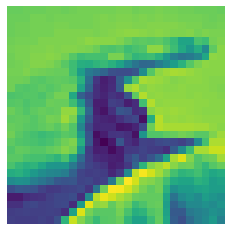

Real: G
Predicted: G


In [28]:
img = X_test[0]
plt.imshow(img.reshape(28,28))
plt.axis('off')
plt.show()
print('Real:',class_names[y_test[0].astype(int)])
print('Predicted:',class_names[ens_preds[0].astype(int)])

# Searching for the best possible weights

In [29]:
### trying every weight combination and finding for the best
res = []
for w1 in range(0,5):
    for w2 in range(0,5):
        weights = [w1/10.,w2/10.]
        weighted_preds = tf.tensordot(preds,weights,axes=((0),(0)))
        ens_preds = np.argmax(weighted_preds,axis=1)
        ensemble_accuracy = accuracy_score(y_test, ens_preds)
        res.append({'w1':weights[0],'w2':weights[1],'acc':ensemble_accuracy})

res = pd.DataFrame(res,columns={'w1','w2','acc'})      

In [30]:
res.sort_values(by=['acc'], ascending=False,ignore_index=True)

,w2,acc,w1
0,0.2,0.949665,0.3
1,0.3,0.947992,0.4
2,0.2,0.947434,0.2
3,0.1,0.947434,0.1
4,0.3,0.947434,0.3
5,0.4,0.947434,0.4
6,0.2,0.945901,0.4
7,0.1,0.945901,0.2
8,0.3,0.941718,0.2
9,0.4,0.941439,0.3
